## Retail Sales Analysis

### Importación de librerías


In [7]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

# 1. Quitar el límite de columnas en el resumen .info(), por si acaso tuviera muchas columas
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_colwidth', None) #mostrar todo el contenido de la fila
pd.set_option('display.max_columns', None)

### Visión global del dataset

In [8]:
#Concexión con duckdb para poder hacer consultas SQL 
con = duckdb.connect()

#Creación de la tabla con la información de los datasets
con.execute("CREATE OR REPLACE VIEW retail_sales AS SELECT * FROM read_csv_auto('us_retail_sales.csv', union_by_name=True, sample_size=100000)")

#Consulta
query = """
SELECT * FROM retail_sales

"""
#Conversión a df
df_retail_sales = con.execute(query).df()

#Información general
df_retail_sales.info(verbose=True, show_counts=True)
display(df_retail_sales.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22620 entries, 0 to 22619
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   sales_month       22620 non-null  datetime64[us]
 1   naics_code        20184 non-null  object        
 2   kind_of_business  22620 non-null  object        
 3   reason_for_null   594 non-null    object        
 4   sales             22026 non-null  Int64         
dtypes: Int64(1), datetime64[us](1), object(3)
memory usage: 905.8+ KB


,sales_month,naics_code,kind_of_business,reason_for_null,sales
0,1992-01-01,441,Motor vehicle and parts dealers,None,29811
1,1992-01-01,4411,Automobile dealers,None,25800
2,1992-01-01,"4411, 4412",Automobile and other motor vehicle dealers,None,26788
3,1992-01-01,44111,New car dealers,None,24056
4,1992-01-01,44112,Used car dealers,None,1744


### Tendencias en los datos

El resultado de un "trend" es una serie de datos temporales y numéricos. En una time series, los datos temporales se encuentra en el eje X y el valor númerico en el eje Y, de modo que podemos ir viendo la evolución de ese valor a lo largo del tiempo. 

Por ejemplo, podemos comprobar la tendencia de titak de "retail an food services sales": 

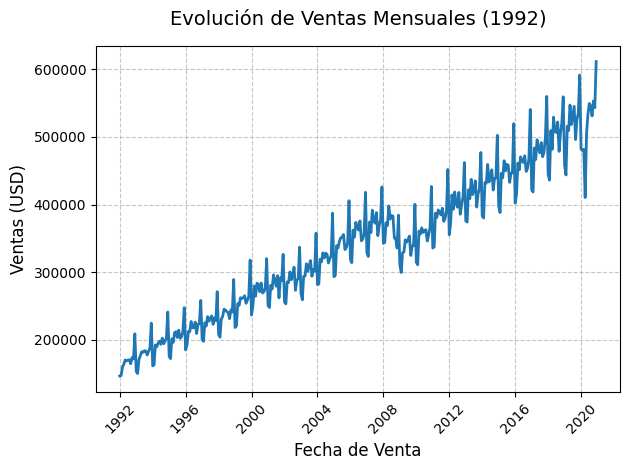

In [9]:
# Realizamos la consulta y convertimos a df
df_food_services = con.execute("""
            SELECT sales_month, 
            sales
            FROM retail_sales
            WHERE kind_of_business = 'Retail and food services sales, total'
            """).df()

# Mostramos el dataframe
df_food_services.head()

# Visualizamos el trend
# 3. Crear la visualización
plt.plot(df_food_services['sales_month'], df_food_services['sales'], linestyle='-', color='#1f77b4', linewidth=2)

# Personalización de etiquetas y título
plt.title('Evolución de Ventas Mensuales (1992)', fontsize=14, pad=15)
plt.xlabel('Fecha de Venta', fontsize=12)
plt.ylabel('Ventas (USD)', fontsize=12)

# Mejorar el formato de las etiquetas del eje X
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

# Ajustar el diseño para que no se corten las etiquetas
plt.tight_layout()

plt.show()

Como vemos, nuestro gráfico tiene mucho "ruido" y es porque estamos representando la evolución por meses, lo que supone una gran cantidad de registros. Para evitar esto, vamos a agrupar los periodos por años, sumando las ventas de todos los meses: 

In [10]:
#Ejecutamos la consulta
df_food_services_corrected = con.execute("""SELECT sum(sales) as sales, 
                                         date_part('year', sales_month) as sales_year
                                         FROM retail_sales
                                         WHERE kind_of_business = 'Retail and food services sales, total'
                                         GROUP BY sales_year
                                         ORDER BY sales_year ASC
                                         """).df()

# Comprbamos
df_food_services_corrected.head()



,sales,sales_year
0,2014102.0,1992
1,2153095.0,1993
2,2330235.0,1994
3,2450628.0,1995
4,2603794.0,1996


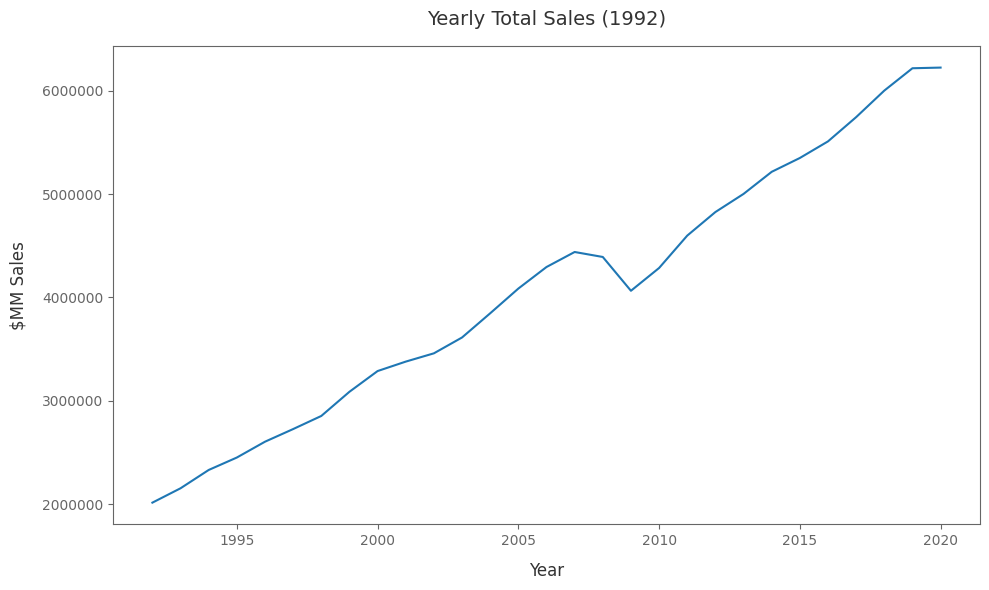

In [11]:
# 2. Configurar el gráfico 
fig, ax = plt.subplots(figsize=(10, 6))

# Trazar la línea (color azul suave, sin marcadores)
ax.plot(df_food_services_corrected['sales_year'], df_food_services_corrected['sales'], color='#1f77b4', linewidth=1.5)

# Configurar el título y las etiquetas de los ejes
ax.set_title('Yearly Total Sales (1992)', fontsize=14, color='#333333', pad=15)
ax.set_xlabel('Year', fontsize=12, color='#333333', labelpad=10)
ax.set_ylabel('$MM Sales', fontsize=12, color='#333333', labelpad=10)

# Configurar el formato del eje X para mostrar año
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

# Formatear el eje Y
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

# Configurar los colores y estilos de los ticks y los bordes (spines)
ax.tick_params(axis='both', colors='#666666', labelsize=10)
for spine in ax.spines.values():
    spine.set_edgecolor('#666666')

# Eliminar la cuadrícula 
ax.grid(False)

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Como vemos, según los diferentes niveles de granularidad (año, mes, semana...) la gráfica será diferente. Según el objetivo que tengamos, tendremos que usar unos valores u otros. 

### Comparación de varios componentes en la misma time series

A veces, nos interesa comparar varias tendencias en una misma gráfica para comparar la evolución entre ellas a lo largo del tiempo, lo que muchas veces ayuda a encontrar ciertos patrones o relaciones interesantes. 

In [12]:
# Realizar la consulta
df_time_series_comparation = con.execute("""SELECT date_part('year', sales_month) as sales_year,
                                         kind_of_business, 
                                         sum(sales) as sales
                                         FROM retail_sales
                                         WHERE kind_of_business in ('Book stores'
                                                                    ,'Sporting goods stores',  
                                                                    'Hobby, toy, and game stores')
                                         GROUP BY sales_year, kind_of_business
                                         ORDER BY sales_year ASC """).df()

df_time_series_comparation.head()

,sales_year,kind_of_business,sales
0,1992,Book stores,8327.0
1,1992,Sporting goods stores,15583.0
2,1992,"Hobby, toy, and game stores",11251.0
3,1993,Book stores,9108.0
4,1993,"Hobby, toy, and game stores",11651.0


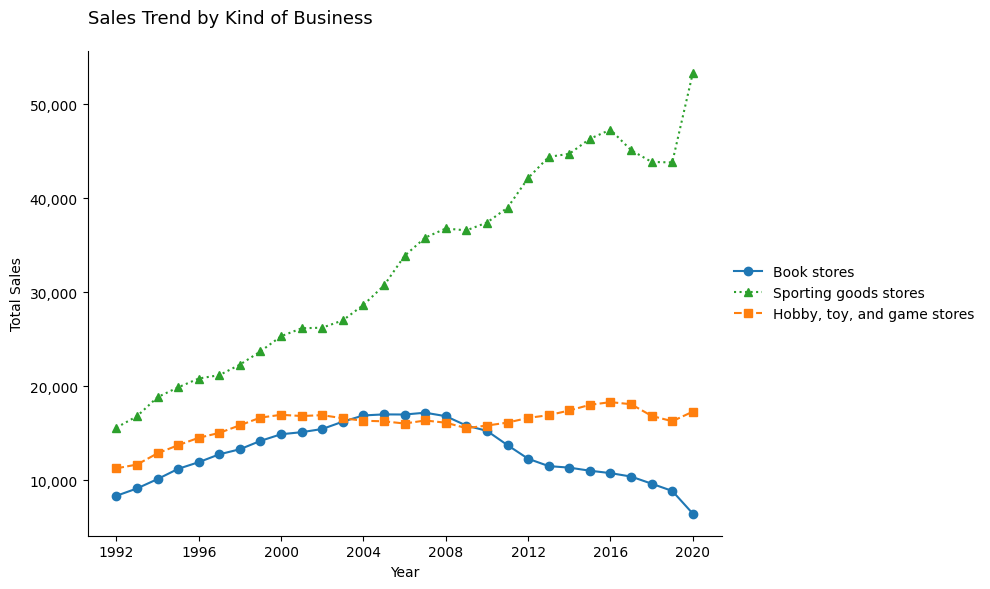

In [13]:
# Definir estilos específicos para cada tipo de negocio
estilos = {
    'Book stores': {'ls': '-', 'marker': 'o', 'color': '#1f77b4'},      # Sólida
    'Hobby, toy, and game stores': {'ls': '--', 'marker': 's', 'color': '#ff7f0e'}, # Rayas
    'Sporting goods stores': {'ls': ':', 'marker': '^', 'color': '#2ca02c'}   # Puntos
}

#Configurar el gráfico

fig, ax = plt.subplots(figsize=(10, 6))

# 3. Graficar cada categoría por separado
for business in df_time_series_comparation['kind_of_business'].unique():
    subset = df_time_series_comparation[df_time_series_comparation['kind_of_business'] == business]
    style = estilos.get(business, {'ls': '-'}) # Estilo por defecto si hubiera más
    
    ax.plot(
        subset['sales_year'], 
        subset['sales'], 
        label=business,
        linewidth=1.5,
        **style
    )

# 4. Estética
ax.set_title('Sales Trend by Kind of Business', fontsize=13, loc='left', pad=20)
ax.set_xlabel('Year', fontsize=10)
ax.set_ylabel('Total Sales', fontsize=10)

# Formatear ejes
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True)) # Solo años enteros
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')) # Separador de miles

# Eliminar bordes innecesarios
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Leyenda fuera del gráfico 
ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('sales_trend_by_business.png', dpi=300)
plt.show()

### Obtener la diferencia entre dos categorías a lo largo del tiempo

En esta ocasión vamos a obtener la diferencia de ventas entre ropa de hombre y de mujer a lo largo del tiempo. Primero, visualizaremos su tendencia en una misma gráfica y luego representaremos la evolución de su diferencia con el paso del tiempo

In [14]:
df_clothings = con.execute("""SELECT date_part('year',sales_month) as sales_year
                                    ,kind_of_business
                                    ,sum(sales) as sales
                                FROM retail_sales
                                WHERE kind_of_business in ('Men''s clothing stores'
                                ,'Women''s clothing stores')
                                GROUP BY sales_year, kind_of_business
                                ORDER BY sales_year ASC""").df()

df_clothings.head()

,sales_year,kind_of_business,sales
0,1992,Women's clothing stores,31815.0
1,1992,Men's clothing stores,10179.0
2,1993,Men's clothing stores,9962.0
3,1993,Women's clothing stores,32350.0
4,1994,Men's clothing stores,10032.0


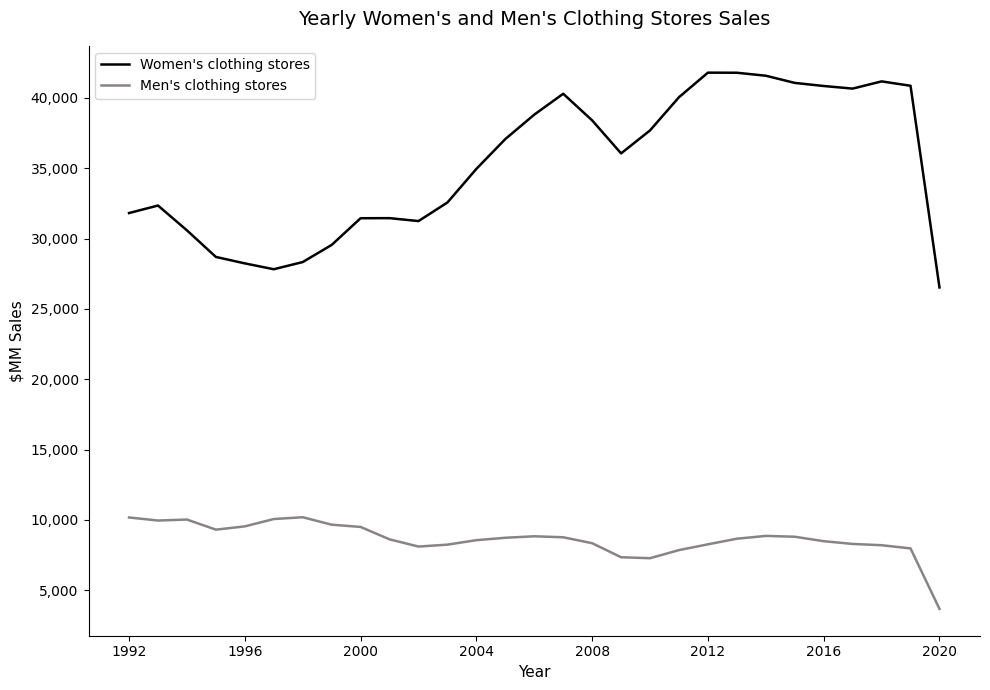

In [15]:
# 2. Inicializar la figura y los ejes (Crucial para evitar el error anterior)
fig, ax = plt.subplots(figsize=(10, 7), facecolor='white')

# 3. Definir estilos para que coincidan con la imagen (Negro para Women, Gris para Men)
estilos = {
    "Women's clothing stores": {'color': 'black', 'label': "Women's clothing stores"},
    "Men's clothing stores": {'color': "#888484", 'label': "Men's clothing stores"} # Gris
}

# 4. Graficar cada línea
for business in ["Women's clothing stores", "Men's clothing stores"]:
    subset = df_clothings[df_clothings['kind_of_business'] == business]
    style = estilos[business]
    
    ax.plot(
        subset['sales_year'], 
        subset['sales'], 
        linewidth=1.8,
        **style
    )

# 5. Estética idéntica a la Figura 3-6
ax.set_title("Yearly Women's and Men's Clothing Stores Sales", fontsize=14, pad=15)
ax.set_xlabel('Year', fontsize=11)
ax.set_ylabel('$MM Sales', fontsize=11)

# Formatear eje X para que solo muestre años enteros
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Formatear eje Y con separador de miles (coma)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Quitar bordes superior y derecho
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Configurar la leyenda en la esquina superior izquierda (sin recuadro)
ax.legend(loc='upper left', frameon=True)

# Ajustar el diseño
plt.tight_layout()
plt.show()

En este gráfico, se visuzaliza como han evolucionado por separado las ventas de ropa de hombre y mujer con el tiempo. A continuación, vamos a calcular como ha evolucionado la diferencia entre sus valores según el paso del tiempo. 

Primero, necesitamos conseguir una columna para cada categoría según el año: 

In [16]:
# Realizamos la consulta
df_clothings_perc = con.execute("""SELECT date_part('year',sales_month) as sales_year
                                ,sum(case when kind_of_business = 'Women''s clothing stores'
                                    then sales
                                    end) as womens_sales
                                ,sum(case when kind_of_business = 'Men''s clothing stores'
                                    then sales
                                    end) as mens_sales
                                FROM retail_sales
                                WHERE kind_of_business in ('Men''s clothing stores'
                                    ,'Women''s clothing stores')
                                GROUP BY sales_year
                                ORDER BY sales_year ASC""").df()

# Comprobamos
df_clothings_perc.head()

,sales_year,womens_sales,mens_sales
0,1992,31815.0,10179.0
1,1993,32350.0,9962.0
2,1994,30585.0,10032.0
3,1995,28696.0,9315.0
4,1996,28238.0,9546.0


Una vez tenemos esto, calculamos la diferencia restando una categoría a la otra (valdría cualquiera puesto que luego podemos mostrar la diferencia en valor absoluto)

In [17]:
df_clothings_dif = con.execute("""SELECT sales_year
                                ,womens_sales - mens_sales as womens_minus_mens
                                ,mens_sales - womens_sales as mens_minus_womens
                                FROM
                                (
                                    SELECT date_part('year',sales_month) as sales_year
                                    ,sum(case when kind_of_business = 'Women''s clothing stores'
                                        then sales
                                        end) as womens_sales
                                    ,sum(case when kind_of_business = 'Men''s clothing stores'
                                        then sales
                                        end) as mens_sales
                                    FROM retail_sales
                                    WHERE kind_of_business in ('Men''s clothing stores'
                                    ,'Women''s clothing stores')
                                    and sales_month <= '2019-12-01'
                                    GROUP BY sales_year) as a 
                                    ORDER BY sales_year ASC""").df()

df_clothings_dif.head()

,sales_year,womens_minus_mens,mens_minus_womens
0,1992,21636.0,-21636.0
1,1993,22388.0,-22388.0
2,1994,20553.0,-20553.0
3,1995,19381.0,-19381.0
4,1996,18692.0,-18692.0


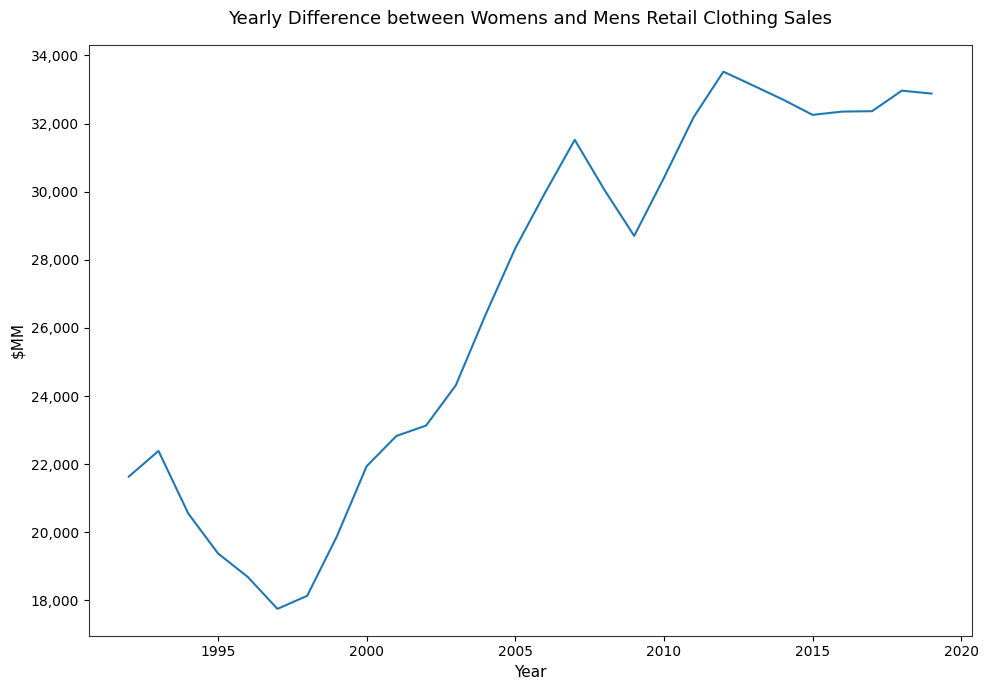

In [18]:
# Visualización
# 2. Configurar la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 7), facecolor='white')

# 3. Graficar la columna womens_minus_mens
ax.plot(df_clothings_dif['sales_year'], df_clothings_dif['womens_minus_mens'], color='#1f77b4', linewidth=1.5)

# 4. Estética para igualar la imagen de referencia
ax.set_title('Yearly Difference between Womens and Mens Retail Clothing Sales', 
             fontsize=13, pad=15)
ax.set_xlabel('Year', fontsize=11)
ax.set_ylabel('$MM', fontsize=11)

# Formatear eje X para mostrar años enteros (ej: cada 5 años como en la imagen)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

# Formatear eje Y con separador de miles (comas)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Mantener el recuadro del gráfico (spines visibles) como en la imagen original
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('#333333')

# Ajustar los ticks para que sean más legibles
ax.tick_params(axis='both', labelsize=10)

# Quitar la cuadrícula (según la imagen de referencia)
ax.grid(False)

plt.tight_layout()
plt.show()

### Cálculo del procentaje del total 

A veces, nos interesará calcular en que medida una variable aporta valor al total a lo largo del tiempo. En este caso, vamos a calcular para cada año cuál ha sido el porcentaje de la cantidad total de ventas para ropa de hombre y de mujer. Para ello, lo haremos a través un SELF JOIN (unión de una tabla consigo misma):

In [19]:
df_clothing_perc_total = con.execute("""
    SELECT sales_month
         , kind_of_business
         , sales * 100.0 / total_sales as pct_total_sales -- Usamos 100.0 para asegurar decimales
    FROM (
        SELECT a.sales_month
             , a.kind_of_business
             , a.sales
             , sum(b.sales) as total_sales
        FROM retail_sales a
        JOIN retail_sales b ON a.sales_month = b.sales_month
             AND b.kind_of_business IN ('Men''s clothing stores', 'Women''s clothing stores')
        WHERE a.kind_of_business IN ('Men''s clothing stores', 'Women''s clothing stores')
        GROUP BY a.sales_month, a.kind_of_business, a.sales 
        ORDER BY a.sales_month ASC
    ) aa
""").df()


df_clothing_perc_total.head()

,sales_month,kind_of_business,pct_total_sales
0,1992-01-01,Men's clothing stores,27.233877
1,1992-01-01,Women's clothing stores,72.766123
2,1992-02-01,Men's clothing stores,24.839562
3,1992-02-01,Women's clothing stores,75.160438
4,1992-03-01,Men's clothing stores,23.324825


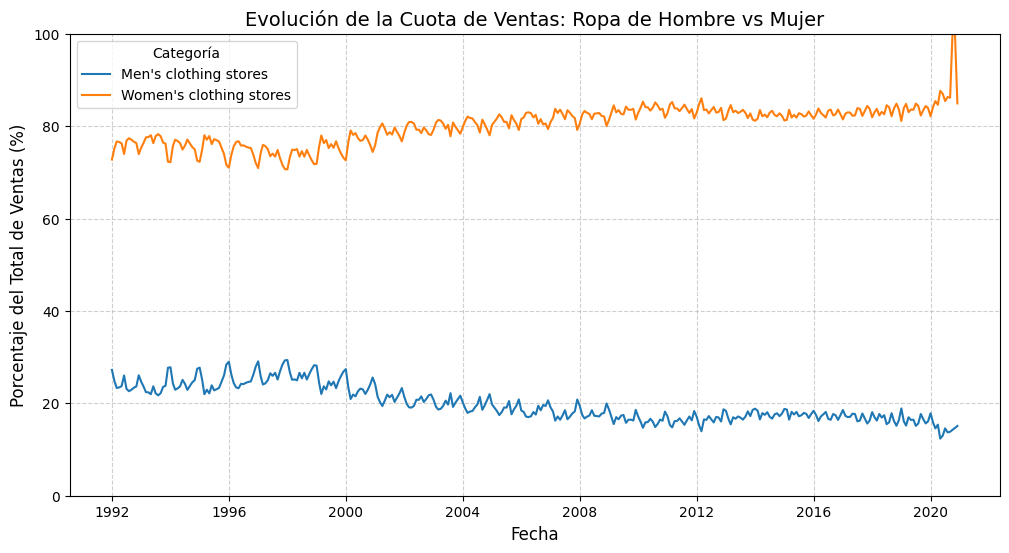

In [20]:
# Visualización
# 1. Aseguramos que la fecha sea de tipo datetime para que el eje X sea correcto
df_clothing_perc_total['sales_month'] = pd.to_datetime(df_clothing_perc_total['sales_month'])

# 2. Creamos la gráfica
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_clothing_perc_total, 
             x='sales_month', 
             y='pct_total_sales', 
             hue='kind_of_business', 
            )

# 3. Formateo estético
plt.title('Evolución de la Cuota de Ventas: Ropa de Hombre vs Mujer', fontsize=14)
plt.ylabel('Porcentaje del Total de Ventas (%)', fontsize=12)
plt.xlabel('Fecha', fontsize=12)
plt.ylim(0, 100) # El porcentaje va de 0 a 100
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Categoría')
plt.show()

###  Analizar el cambio (%) a partir de un punto base

En este caso, vamos a comprobar como varía el porcentaje (aumenta o disminuye) cogiendo como referencia el año 1992. De este modo, sabremos si por ejemplo la ropa de chica ha experiementado un 30% más de ventas en 2020 respecto al valor de venta de 1992. 

Primer obtenemos las sales por año y una columna que determina el índice (ventas de 1992):


In [21]:
df_index = con.execute("""SELECT sales_year, sales
,first_value(sales) over (order by sales_year) as index_sales
FROM
(
 SELECT date_part('year',sales_month) as sales_year
 ,sum(sales) as sales
 FROM retail_sales
 WHERE kind_of_business = 'Women''s clothing stores'
 GROUP BY sales_year
) a
""").df()

df_index.head()

,sales_year,sales,index_sales
0,1992,31815.0,31815.0
1,1993,32350.0,31815.0
2,1994,30585.0,31815.0
3,1995,28696.0,31815.0
4,1996,28238.0,31815.0


Ahora calculamos el porcentaje de variación respecto al índice para cada fila: 

In [22]:
df_perc_dif = con.execute("""SELECT sales_year, sales
,(sales / first_value(sales) over (order by sales_year) - 1) * 100
 as pct_from_index
FROM
(
 SELECT date_part('year',sales_month) as sales_year
 ,sum(sales) as sales
 FROM retail_sales
 WHERE kind_of_business = 'Women''s clothing stores'
 GROUP BY sales_year
) a""").df()

df_perc_dif.head()

,sales_year,sales,pct_from_index
0,1992,31815.0,0.000000
1,1993,32350.0,1.681597
2,1994,30585.0,-3.866101
3,1995,28696.0,-9.803552
4,1996,28238.0,-11.243124


Lo hacemos para los dos tipos de negocio para poder luego representarlo en un mismo gráfico y ver las diferencias: 

In [23]:
df_perc_dif_both = con.execute("""SELECT sales_year, kind_of_business, sales
,(sales / first_value(sales) over (partition by kind_of_business
 order by sales_year)
 - 1) * 100 as pct_from_index
FROM
(
 SELECT date_part('year',sales_month) as sales_year
 ,kind_of_business
 ,sum(sales) as sales
 FROM retail_sales
 WHERE kind_of_business in ('Men''s clothing stores'
 ,'Women''s clothing stores')
 and sales_month <= '2019-12-31'
 GROUP BY sales_year, kind_of_business
) a"""
).df()

df_perc_dif_both.head()

,sales_year,kind_of_business,sales,pct_from_index
0,1992,Men's clothing stores,10179.0,0.000000
1,1993,Men's clothing stores,9962.0,-2.131840
2,1994,Men's clothing stores,10032.0,-1.444150
3,1995,Men's clothing stores,9315.0,-8.488064
4,1996,Men's clothing stores,9546.0,-6.218686


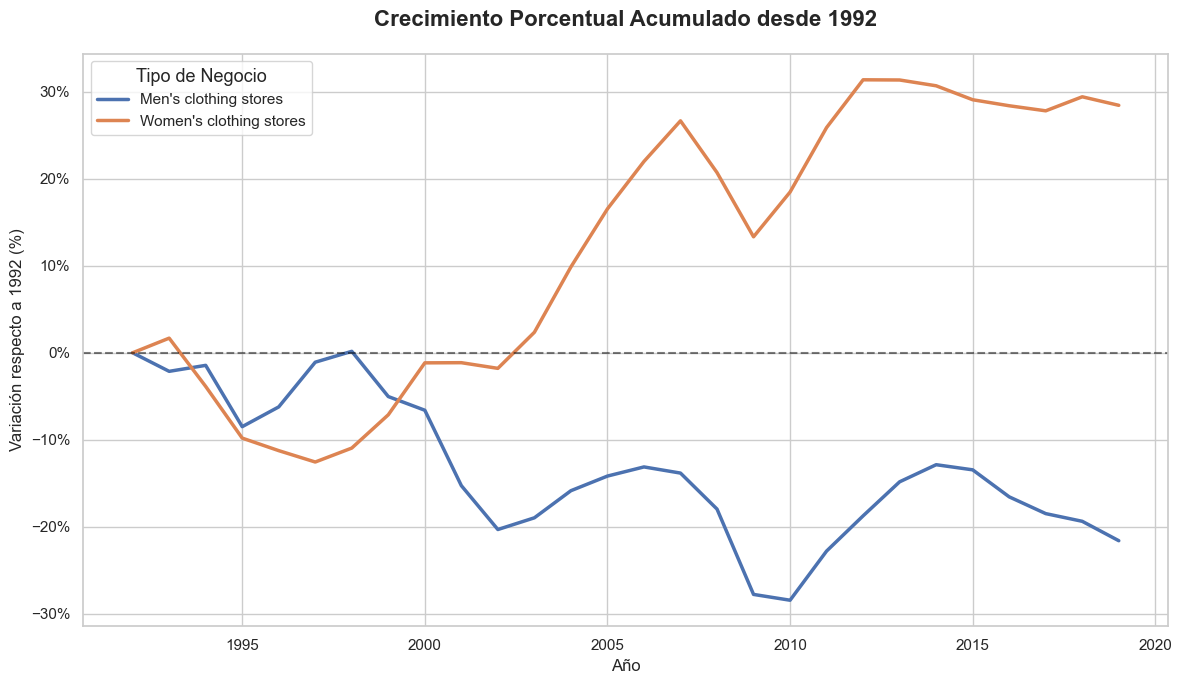

In [24]:
# 1. Configurar el estilo visual
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

# 2. Crear la gráfica de líneas
# x='sales_year' son los años, y='pct_from_index' es el crecimiento, hue separa por categoría
ax = sns.lineplot(
    data=df_perc_dif_both, 
    x='sales_year', 
    y='pct_from_index', 
    hue='kind_of_business',          # Añade puntos en cada año
    linewidth=2.5
)

# 3. Personalización de la gráfica
plt.title('Crecimiento Porcentual Acumulado desde 1992', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Variación respecto a 1992 (%)', fontsize=12)
plt.xlabel('Año', fontsize=12)

# Añadimos una línea horizontal en el 0 (nuestro punto de referencia)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)

# Mejorar la leyenda
plt.legend(title='Tipo de Negocio', title_fontsize='13', fontsize='11', loc='upper left')

# Formatear el eje Y para mostrar el símbolo de %
import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.tight_layout()
plt.savefig('clothing_sales_growth.png', dpi=300)
plt.show()

### Rolling Time Windows

Es lo que nos permite realizar funciones sobre el periodos de tiempo específicos como "los últimos 12 meses".

Primero, debemos determinar el tamaño de la ventana, que hacer referencia al número de períodos que vamos a incluir en el cálculo.

Lo segundo corresponde a la función de agregación que vamos a utilizar. La más común es AVG, pero MIN, MAX, SUM... también pueden ser calculadas. 

Por ultimo, queda elegir como vamos a divir en partes / grupos los datos incluidos en la ventana. El análisis igual necesita resetear la ventana y el cálculo cada año o necesitamos periodo distinto para componente o grupo. La partición vendrá determinada por GROUP BY y PARTITION BY. 

De este modo: 

In [25]:
df_rolling_window = con.execute("""SELECT a.sales_month
,a.sales
,b.sales_month as rolling_sales_month
,b.sales as rolling_sales
FROM retail_sales a
JOIN retail_sales b on a.kind_of_business = b.kind_of_business
 and b.sales_month between a.sales_month - interval '11 months'
 and a.sales_month
 and b.kind_of_business = 'Women''s clothing stores'
WHERE a.kind_of_business = 'Women''s clothing stores'
and a.sales_month = '2019-12-01'
ORDER BY rolling_sales_month ASC""").df()

df_rolling_window.head()

,sales_month,sales,rolling_sales_month,rolling_sales
0,2019-12-01,4496,2019-01-01,2511
1,2019-12-01,4496,2019-02-01,2680
2,2019-12-01,4496,2019-03-01,3585
3,2019-12-01,4496,2019-04-01,3604
4,2019-12-01,4496,2019-05-01,3807


In [26]:
df_rolling_window_avg = con.execute("""SELECT a.sales_month
,a.sales
,avg(b.sales) as moving_avg
,count(b.sales) as records_count
FROM retail_sales a
JOIN retail_sales b on a.kind_of_business = b.kind_of_business
 and b.sales_month between a.sales_month - interval '11 months'
 and a.sales_month
 and b.kind_of_business = 'Women''s clothing stores'
WHERE a.kind_of_business = 'Women''s clothing stores'
and a.sales_month >= '1993-01-01'
GROUP BY 1,2
ORDER BY a.sales_month ASC
                                    
""").df()

df_rolling_window_avg.head()

,sales_month,sales,moving_avg,records_count
0,1993-01-01,2123,2672.083333,12
1,1993-02-01,2005,2673.250000,12
2,1993-03-01,2442,2676.500000,12
3,1993-04-01,2762,2684.583333,12
4,1993-05-01,2873,2694.666667,12


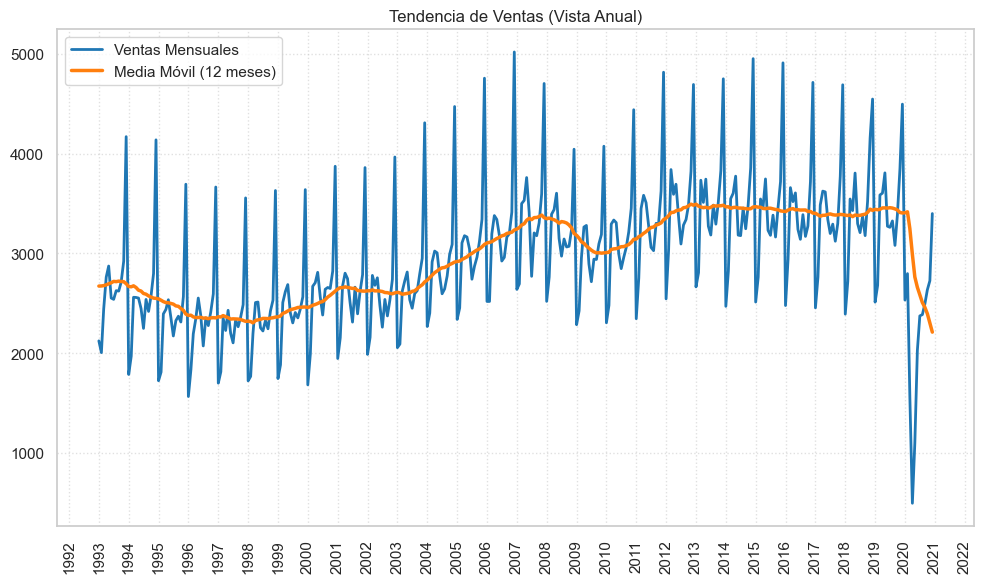

In [27]:
# 2. Configuración del Gráfico
plt.figure(figsize=(10, 6))

# Línea 1: Ventas Reales (Azul sólido con puntos)
plt.plot(df_rolling_window_avg['sales_month'], df_rolling_window_avg['sales'], 
          linestyle='-', color='#1f77b4', linewidth=2, label='Ventas Mensuales')

# Línea 2: Media Móvil (Naranja discontinuo)
plt.plot(df_rolling_window_avg['sales_month'], df_rolling_window_avg['moving_avg'], 
         marker='', linestyle='-', color='#ff7f0e', linewidth=2.5, label='Media Móvil (12 meses)')

# --- CONFIGURACIÓN DEL EJE X (SOLO AÑOS) ---
ax = plt.gca() # Obtenemos el objeto del eje actual

# 1. Le decimos que ponga un "tick" o marca SOLO en cada año
ax.xaxis.set_major_locator(mdates.YearLocator())

# 2. Le decimos que el formato de esa marca sea SOLO el año (ej. 1993)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=90)
# -------------------------------------------

plt.title('Tendencia de Ventas (Vista Anual)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()